## Dueling DQN

#### Autores:
- Celia Quiles Aleman - 202315604@alu.comillas.edu
 - Álvaro Ezquerro Pérez - alvaroezquerro@alu.comillas.edu
 - María Calvo de Mora Román - 202320059@alu.comillas.edu

#### Desarrollado por:
Álvaro Ezquerro Pérez

In [1]:
import torch
import torch.nn as nn
import numpy as np

from src.DDQN_nn import Memory, DuelingQNetwork
from src.utils.plotting import plot_blackjack_performance
from tqdm import tqdm
import gym

import warnings
warnings.filterwarnings('ignore')

In [2]:
STORE_PATH = 'src/models/'
MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.001
GAMMA = 0.99
BATCH_SIZE = 64
TAU = 0.001
RANDOM_REWARD_STD = 0.1

In [3]:
# Definir el entorno
env = gym.make('Blackjack-v1', natural=False)

# Información del entorno
print("Action Space {}". format(env.action_space))
print("State Space {}.". format(env.observation_space))

Action Space Discrete(2)
State Space Tuple(Discrete(32), Discrete(11), Discrete(2)).


In [4]:
# Instantiate rng
rng = np.random.default_rng(2024)
torch.manual_seed(2024)

# Instantiate the memory
memory = Memory(500000)

# Instantiate the networks
input_size = len(env.observation_space)
num_actions = env.action_space.n
primary_network = DuelingQNetwork(input_size, num_actions)
target_network = DuelingQNetwork(input_size, num_actions)

# Define optimizer and loss function
optimizer = torch.optim.Adam(primary_network.parameters())
loss_fn = nn.MSELoss()

In [5]:
def choose_action(state, network, eps, rng):
    if eps is not None and rng.random() < eps :
        return rng.integers(0, num_actions)
    else:
        return np.argmax(network(state.reshape(1, -1)).detach().numpy())


In [6]:
def train(primary_network, memory, target_network=None):
    if memory.num_samples < BATCH_SIZE * 3:
        return 0
    
    batch = memory.sample(BATCH_SIZE)
    states = np.array([val[0] for val in batch])
    actions = np.array([val[1] for val in batch])
    rewards = np.array([val[2] for val in batch])
    next_states = np.array([(np.zeros(input_size) if val[3] is None else val[3]) for val in batch])
    
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int16)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    
    # Predict Q(s,a) given the batch of states
    prim_qt = primary_network(states)
    
    # Predict Q(s',a') from the evaluation network
    prim_qtp1 = primary_network(next_states)
    
    target_q = prim_qt.clone().detach()  # Target Q-value
    
    with torch.no_grad():
        if target_network is None:
            prim_qtp1_values = prim_qtp1.detach()
            updates = rewards + GAMMA * torch.max(prim_qtp1_values, dim=1)[0] * (1 - next_states.sum(dim=1).eq(0).float())
        else:
            prim_action_tp1 = torch.argmax(prim_qtp1, dim=1)
            q_from_target = target_network(next_states)
            updates = rewards + GAMMA * q_from_target[torch.arange(BATCH_SIZE), prim_action_tp1]
    
    target_q[torch.arange(BATCH_SIZE), actions.long()] = updates
    
    loss_fn = nn.MSELoss()
    loss = loss_fn(prim_qt, target_q)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if target_network is not None:
        for target_param, primary_param in zip(target_network.parameters(), primary_network.parameters()):
            target_param.data.copy_(primary_param.data * (1.0 - TAU) + target_param.data * TAU)
    
    return loss.item()

### Dueling DQN

In [8]:
primary_network = torch.load(STORE_PATH + f"pDDQN_{200000}")

In [7]:
num_episodes = 200_000
eps = MAX_EPSILON
render = False
steps = 0
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    while True:
        if render:
            env.render()
            
        state = torch.tensor(state, dtype=torch.float32)
        action = choose_action(state, primary_network, eps, rng)
        next_state, reward, done, tr, info = env.step(action)
        reward = np.random.normal(1.0, RANDOM_REWARD_STD)
        if done:
            next_state = None

        # store in memory
        memory.add_sample((state, action, reward, next_state))

        loss = train(primary_network, memory, target_network=target_network)

        state = next_state

        # exponentially decay the eps value
        steps += 1
        eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-LAMBDA * steps)
        
        if done:
            break

print(f"Model trained with {num_episodes} episodes")

torch.save(primary_network, STORE_PATH + f"pDDQN_{num_episodes}")

100%|██████████| 200000/200000 [09:31<00:00, 349.70it/s]


Model trained with 200000 episodes


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2716.78it/s]


Average reward: -0.175, Average episode length: 1.0


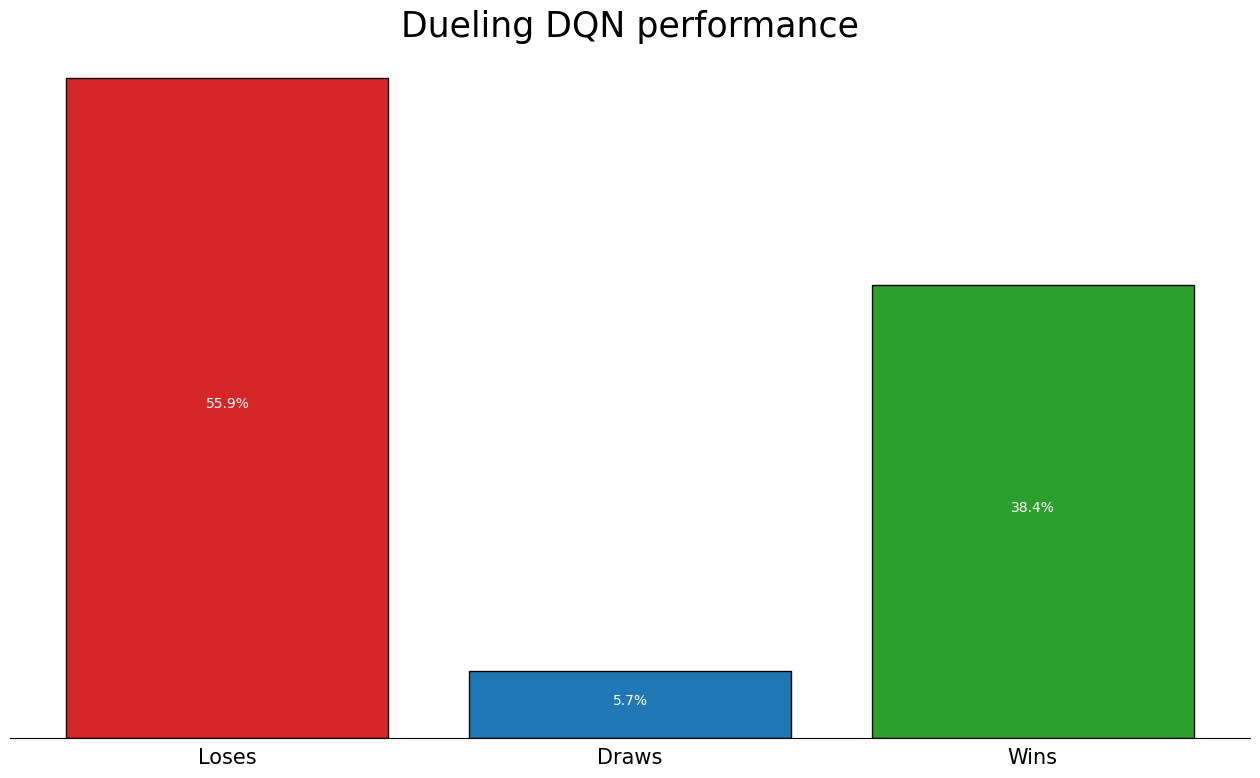

In [9]:
def evaluate_duelingdqn_agent(env, network, num_episodes=1000):
    total_rewards = []
    total_steps = 0

    for _ in tqdm(range(num_episodes)):
        state, _ = env.reset()
        episode_reward = 0
        episode_steps = 0

        while True:
            state = torch.tensor(state, dtype=torch.float32)
            action = choose_action(state, network, None, rng)
            next_state, reward, done, _, _ = env.step(action)

            episode_reward += reward
            episode_steps += 1

            if done:
                break

            state = next_state


        total_rewards.append(episode_reward) 
        total_steps += episode_steps

    avg_reward = sum(total_rewards) / num_episodes
    avg_episode_length = total_steps / num_episodes

    return avg_reward, avg_episode_length, total_rewards

# Example usage:
avg_reward, avg_episode_length, total_rewards= evaluate_duelingdqn_agent(env, primary_network, num_episodes=1000)
print(f"Average reward: {avg_reward}, Average episode length: {avg_episode_length}")
plot_blackjack_performance(total_rewards, "Dueling DQN performance")

In [10]:
env.close()

### Dueling QN

In [11]:
# Definir el entorno
env = gym.make('Blackjack-v1', natural=False)

# Información del entorno
print("Action Space {}". format(env.action_space))
print("State Space {}.". format(env.observation_space))

Action Space Discrete(2)
State Space Tuple(Discrete(32), Discrete(11), Discrete(2)).


In [12]:
# Instantiate rng
rng = np.random.default_rng(2024)
torch.manual_seed(2024)

# Instantiate the memory
memory = Memory(500000)

# Instantiate the networks
input_size = len(env.observation_space)
num_actions = env.action_space.n
dueling_network = DuelingQNetwork(input_size, num_actions)

# Define optimizer and loss function
optimizer = torch.optim.Adam(dueling_network.parameters())
loss_fn = nn.MSELoss()

In [13]:
dueling_network = torch.load(STORE_PATH + f"pDuelingQN_{100000}")

In [27]:
num_episodes = 100_000
eps = MAX_EPSILON
render = False
steps = 0
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    while True:
        if render:
            env.render()
            
        state = torch.tensor(state, dtype=torch.float32)
        action = choose_action(state, dueling_network, eps, rng)
        next_state, reward, done, tr, info = env.step(action)
        reward = np.random.normal(1.0, RANDOM_REWARD_STD)
        if done:
            next_state = None

        # store in memory
        memory.add_sample((state, action, reward, next_state))

        loss = train(dueling_network, memory, target_network=None)

        state = next_state

        # exponentially decay the eps value
        steps += 1
        eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-LAMBDA * steps)
        
        if done:
            break

print(f"Model trained with {num_episodes} episodes")

torch.save(dueling_network, STORE_PATH + f"pDuelingQN_{num_episodes}")

100%|██████████| 100000/100000 [04:29<00:00, 371.38it/s]

Model trained with 100000 episodes


100%|██████████| 1000/1000 [00:00<00:00, 2723.31it/s]


Average reward: -0.185, Average episode length: 1.0


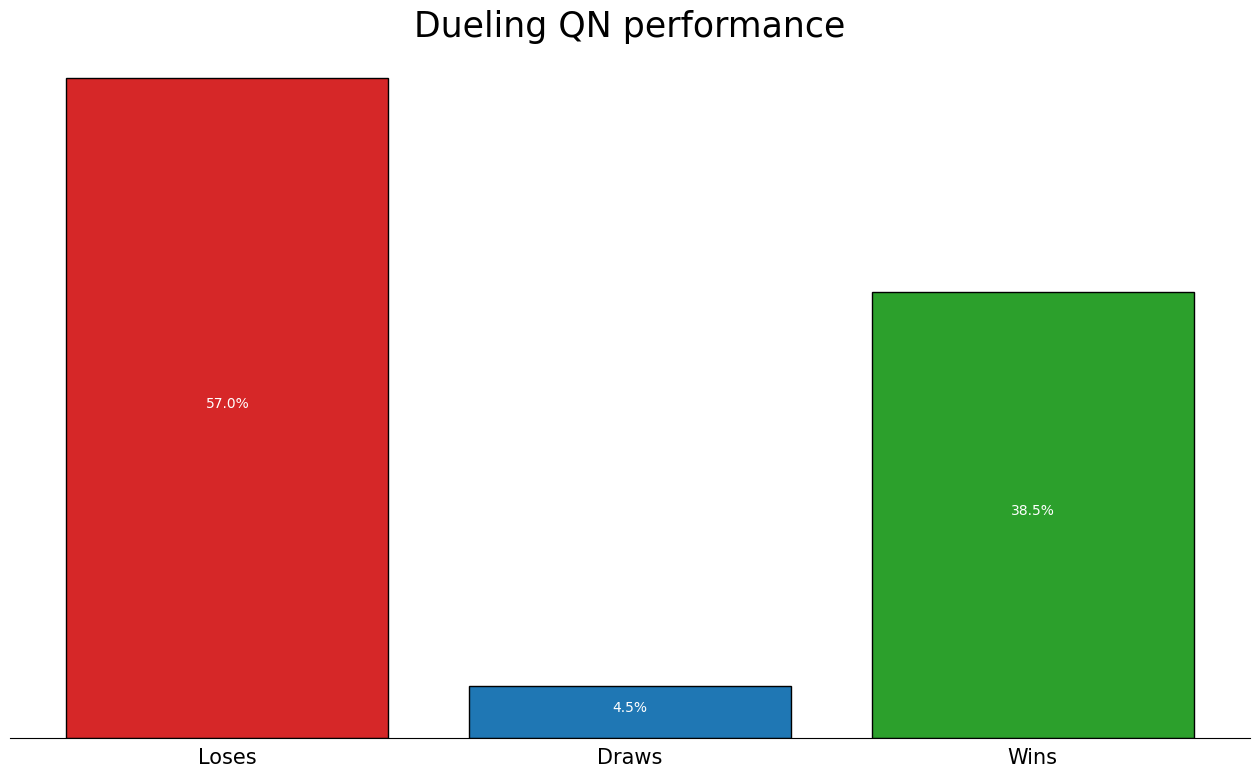

In [15]:
def evaluate_duelingdqn_agent(env, network, num_episodes=1000):
    total_rewards = []
    total_steps = 0

    for _ in tqdm(range(num_episodes)):
        state, _ = env.reset()
        episode_reward = 0
        episode_steps = 0

        while True:
            state = torch.tensor(state, dtype=torch.float32)
            action = choose_action(state, network, None, rng)
            next_state, reward, done, _, _ = env.step(action)

            episode_reward += reward
            episode_steps += 1

            if done:
                break

            state = next_state


        total_rewards.append(episode_reward) 
        total_steps += episode_steps

    avg_reward = sum(total_rewards) / num_episodes
    avg_episode_length = total_steps / num_episodes

    return avg_reward, avg_episode_length, total_rewards

# Example usage:
avg_reward, avg_episode_length, total_rewards= evaluate_duelingdqn_agent(env, dueling_network, num_episodes=1000)
print(f"Average reward: {avg_reward}, Average episode length: {avg_episode_length}")
plot_blackjack_performance(total_rewards, "Dueling QN performance")